### Import and preprocess data

In [1]:
# Import libraries and data 
import scipy.io as sio
from sklearn.model_selection import TimeSeriesSplit
import pandas as pd
import copy
import pickle
import numpy as np
from scipy.signal import find_peaks
from os.path import dirname, join as pjoin
import datetime
import csv
import math
import sys
sys.path.insert(1,'../')
import Tools.data_processing as dp
import Tools.data_movement as dm 
from auxiliary_functions import get_candidates, detect_flat_plat

fDOM_raw_data = dm.read_in_preprocessed_timeseries('../Data/converted_data/julian_format/fDOM_raw_10.1.2011-9.4.2020.csv')
stage_data = dm.read_in_preprocessed_timeseries('../Data/converted_data/julian_format/stage_10.1.11-1.1.19.csv')
turb_data = dm.read_in_preprocessed_timeseries('../Data/converted_data/julian_format/turbidity_raw_10.1.2011_9.4.2020.csv')
stage_data = dp.align_stage_to_fDOM(fDOM_raw_data, stage_data)

### Detect Stage Rise Algorithm

In [104]:
x = np.array([0,1,2,3,3,4,5,3,2,1,0,1,2,2,1])
params = {'slope_threshold' : 1, 'duration_threshold' : 3}
print(detect_stage_rises_one_window(x, params))

Slopes:  [ 1  1  1  0  1  1 -2 -1 -1 -1  1  1  0 -1]
Contin:  [1. 2. 3. 0. 1. 2. 0. 0. 0. 0. 1. 2. 0. 0.]
[1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


### Import Ground Truth

In [ ]:
# Get ground truth values 
ground_truth_path = '/Users/zachfogg/Desktop/DB-SRRW/Data/manual_annotating_data/annotated_data/Stage_Rise/stage_algo_auto_labeled/stage_rises_0k-300k.csv'
ground_truth_signals = np.zeros(len(stage_data))
with open(ground_truth_path, 'r', newline = '') as gt_file:
    reader = csv.reader(gt_file, delimiter = ',')
    idx = 0 
    for row in reader:
        if row[0] == 'Stage':
            if row[3] == 'rise':
                ground_truth_signals[idx] = 1
            idx+=1

In [4]:
# ground_truth_path = '/Users/zachfogg/Desktop/newnew/stage_rise_labeled_0k-300k.csv'
ground_truth_path = "/Users/zachfogg/Desktop/StageFinalOct21/stage_rise_labeled_0k-300k.csv"
ground_truth_signals = np.zeros(len(stage_data))
with open(ground_truth_path, 'r', newline = '') as gt_file:
    reader = csv.reader(gt_file, delimiter = ',')
    idx = 0 
    for row in reader:
        if row[0] == 'Stage':
            if row[3] == 'TP':
                ground_truth_signals[idx] = 1
            idx+=1

for i in range(1,len(ground_truth_signals)-1):
    if ground_truth_signals[i-1] == ground_truth_signals[i+1] == 0 and ground_truth_signals[i] == 1:
        ground_truth_signals[i] == 0

In [ ]:
count = 0 
for x in ground_truth_signals:
    if x == 1: count +=1 
print(count)

### Training Loop

### Nested K-Fold Cross Validation

In [5]:
# Hyperparameter Bounds 

win_threshold_bounds = (0,.075) # Stage rarely even rises above 1 so this range is more than generous
adj_threshold_bounds = (0,.02)
remove_end_threshold_bounds = (.0005,.003)

small_window_bounds = (3,6) # There are rises that are 3 long which need to be captured 
large_window_bounds = (5,10) # Should not overlap with small window

best_params = {'small_adj_threshold' : 0,
               'large_adj_threshold' : 0,
               'small_win_threshold' : 0,
               'large_win_threshold' : 0,
               'remove_end_threshold' : 0,
               'small_window' : 0,
               'large_window' : 0}

iterations = 688

def label_positives_negatives(predictions, ground_truths):
    TP = TN = FP = FN = 0
    results = []
    for i in range(len(predictions)):
        prediction = predictions[i]
        ground_truth = ground_truths[i]

        if prediction == 1 and ground_truth == 1:
            results.append([prediction, 'TP'])
            TP +=1 
        elif prediction == 1 and ground_truth == 0:
            results.append([prediction, 'FP'])
            FP +=1 
        elif prediction == 0 and ground_truth == 1:
            results.append([prediction,'FN'])
            FN +=1 
        else:
            results.append([prediction, 'TN'])
            TN +=1
    return (TP,TN,FP,FN,results)

In [6]:
num_splits = 5 # Number of train/val/test folds

# df = pd.DataFrame(data = {'data' : stage_data[:,1], 'label' : ground_truth_signals}) # Create training set from data and ground truth

train_test_split = TimeSeriesSplit(num_splits).split(stage_data[:,1])

accumulated_test_metrics = {}

accumulated_test_results = {}

overall_start = datetime.datetime.now()

accumulated_best_params = {}

split = 1 

for train_val_indices, test_indices in train_test_split: # Outer loop performs the "Forward-Chaining"
    
    # Get appropriate data subset
    X_train, y_train = np.take(stage_data[:,1], train_val_indices), np.take(ground_truth_signals, train_val_indices)
    X_test, y_test = np.take(stage_data[:,1], test_indices), np.take(ground_truth_signals, test_indices)

   
    max_fold_metric = 0
    max_result = None  
    max_acc = 0
    print("Split: ",split)
    # Optimize hyper parameters to the training data
    split_start = datetime.datetime.now()
    for iteration in range(iterations):
        
        # Random grid search
        params = {}
        params['small_adj_threshold'] = np.random.uniform(win_threshold_bounds[0], win_threshold_bounds[1])
        params['large_adj_threshold'] = np.random.uniform(win_threshold_bounds[0], win_threshold_bounds[1])

        params['small_win_threshold'] = np.random.uniform(adj_threshold_bounds[0], adj_threshold_bounds[1])
        params['large_win_threshold'] = np.random.uniform(adj_threshold_bounds[0], adj_threshold_bounds[1])

        params['remove_end_threshold'] = np.random.uniform(remove_end_threshold_bounds[0],remove_end_threshold_bounds[1])

        params['small_window'] = np.random.randint(small_window_bounds[0], small_window_bounds[1]+1)
        params['large_window'] = np.random.randint(large_window_bounds[0], large_window_bounds[1]+1)
        
        # Detect stage rises 
        detected_signals = detect_stage_rises(X_train, params)
        
        # Results will hold: [signal, result in comparison to ground truth]
        TP,TN,FP,FN,results = label_positives_negatives(detected_signals, y_train)
        
        TPR = TP/(TP + FN)
        TNR = TN/(TN + FP)
        bal_acc = (TPR + TNR)/2 
        f1_score = (2 * TP)/((2 * TP) + FP + FN)

        acc = f1_score
        if iteration and iteration % int(iterations/2) == 0: print("\nIteration: {}\n".format(iteration))
        if acc > max_acc: 
            max_acc = acc
            max_result = copy.deepcopy(results)
            best_params = copy.deepcopy(params)
#             print('I: {}  F1: {:.4f} BA: {:.4f}  Params: {}  TP: {} TN: {} FP: {} FN: {}'.format(iteration, f1_score, bal_acc, params, TP, TN, FP, FN))
        
    # Test best parameters on testing data 
    predicted_signals = detect_stage_rises(X_test, best_params)
    
    TP,TN,FP,FN,results = label_positives_negatives(predicted_signals, y_test)
    
    TPR = TP/(TP + FN)
    TNR = TN/(TN + FP)
    
    bal_acc = (TPR + TNR)/2 
    f1_score = (2 * TP)/((2 * TP) + FP + FN)
    
#     print("Split: {} test scores, f1: {} BA: {} Time: {}".format(split, f1_score, bal_acc, datetime.datetime.now() - split_start))
    print('Split: {}  F1: {:.4f} BA: {:.4f}  Params: {}  TP: {} TN: {} FP: {} FN: {}  Time: {}'.format(split, f1_score, bal_acc, params, TP, TN, FP, FN, datetime.datetime.now() - split_start))
    accumulated_test_metrics[split] = [f1_score, bal_acc] # Record test metrics of each split
    accumulated_test_results[split] = copy.deepcopy(results) # Record test results (FP,FN,TP,TN for each datapoint) for each split
    accumulated_best_params[split] = copy.deepcopy(best_params) # Record params uses in testing for each split
    
    split+=1

mean_f1 = 0
mean_ba = 0 

for key in accumulated_test_metrics:
    metrics = accumulated_test_metrics[key]
    mean_f1+=metrics[0]
    mean_ba+=metrics[1]

print("Mean Test F1: ", mean_f1/len(accumulated_test_metrics))
print("Mean Test BA: ", mean_ba/len(accumulated_test_metrics))

print(datetime.datetime.now() - overall_start)

# Pickle params from last fold
with open('./stage_algo_exp_results/algo1_best_params.pkl', 'wb') as pck_file:
    pickle.dump(accumulated_best_params[num_splits], pck_file)
    pck_file.close()
    
# Pickle results from last fold 
with open('./stage_algo_exp_results/algo1_test_results.pkl', 'wb') as pck_file:
    pickle.dump(accumulated_test_results[num_splits], pck_file)
    pck_file.close()

# Pickle results from last fold 
with open('./stage_algo_exp_results/algo1_test_metrics.pkl', 'wb') as pck_file:
    pickle.dump(accumulated_test_metrics, pck_file)
    pck_file.close()

Split:  1

Iteration: 344

Split: 1  F1: 0.9081 BA: 0.9965  Params: {'small_adj_threshold': 0.005891945916528088, 'large_adj_threshold': 0.036666764265943876, 'small_win_threshold': 0.006433802857818498, 'large_win_threshold': 0.00192329051780195, 'remove_end_threshold': 0.001409927973476543, 'small_window': 6, 'large_window': 6}  TP: 1141 TN: 36898 FP: 230 FN: 1  Time: 0:02:32.966884
Split:  2

Iteration: 344

Split: 2  F1: 0.9399 BA: 0.9897  Params: {'small_adj_threshold': 0.030932123139539452, 'large_adj_threshold': 0.03393799750447163, 'small_win_threshold': 0.01644315173095221, 'large_win_threshold': 0.016895229904613996, 'remove_end_threshold': 0.002530308806212348, 'small_window': 3, 'large_window': 9}  TP: 931 TN: 37220 FP: 102 FN: 17  Time: 0:05:14.469071
Split:  3

Iteration: 344

Split: 3  F1: 0.9328 BA: 0.9782  Params: {'small_adj_threshold': 0.057292307272747506, 'large_adj_threshold': 0.02947951604022098, 'small_win_threshold': 0.009903615261395887, 'large_win_threshold':

In [12]:
with open('./stage_algo_exp_results/algo4_test_metrics.pkl', 'rb') as pck_file:
    accumulated_test_metrics = pickle.load(pck_file)
    pck_file.close()

mean_f1 = 0
mean_ba = 0 

for key in accumulated_test_metrics:
    metrics = accumulated_test_metrics[key]
    mean_f1+=metrics[0]
    mean_ba+=metrics[1]

print("Mean Test F1: ", mean_f1/len(accumulated_test_metrics))
print("Mean Test BA: ", mean_ba/len(accumulated_test_metrics))


Mean Test F1:  0.872022667989554
Mean Test BA:  0.9335898150778146


     |████████████████████████████████| 292 kB 3.7 MB/s eta 0:00:01


<AxesSubplot:>

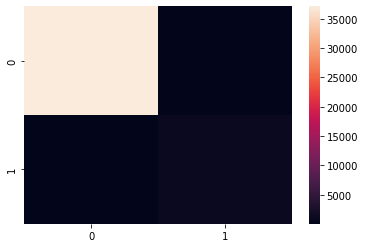

In [130]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
!pip3 install seaborn
import seaborn as sn
import matplotlib.pyplot as plt

pred = np.array([row[0] for row in accumulated_test_results[num_splits][0]])

cm = confusion_matrix(y_test, pred)

sn.heatmap(cm)


In [87]:
# save_params = copy.deepcopy(best_params)
# save_result = copy.deepcopy(max_result)
# save_params2 = copy.deepcopy(best_params)
# save_result2 = copy.deepcopy(max_result)
save_params3 = copy.deepcopy(best_params)
save_result3 = copy.deepcopy(max_result)


In [47]:
params = {'w1_slope_threshold': 0.08897139651302588, 'w1_duration_threshold': 18, 'w2_slope_threshold': 0.0443535992752028, 'w2_duration_threshold': 6, 'min_height': 0.06586482147779672}  TP: 820 TN: 37042 FP: 16 FN: 392  Time: 0:01:38.449921
predicted_signals = detect_stage_rises(stage_data[:,1], params)
    
TP,TN,FP,FN,results = label_positives_negatives(predicted_signals, ground_truth_signals)

In [49]:
print((2 * TP)/((2 * TP) + FP + FN))

0.8918977626529578


In [50]:
# Print out signals to reconsider labels
# Get stage rises
# fDOM_cand_params = {'prom' : [4,None],
#                     'width': [None, None],   These are the params for fDOM pp cand
#                     'wlen' : 200,
#                     'dist' : 1,
#                     'rel_h': .6}

fDOM_cand_params = {'prom' : [4,None],
                    'width': [None, 2],
                    'wlen' : 200,
                    'dist' : 1,
                    'rel_h': .6}

# turb_cand_params = {'prom' : [6,None],       These are the params that were used to label turb cand 0-100k
#                     'width': [None, None],
#                     'wlen' : 200,
#                     'dist' : 1,
#                     'rel_h': .6}

turb_cand_params = {'prom' : [6,None],
                    'width': [None, None],    # was 2 for skyrocketing
                    'wlen' : 200,
                    'dist' : 1,
                    'rel_h': .6}   # was .5 for skyrocketing 

# Get fDOM and turb candiate peaks
fDOM_peaks, fDOM_props = get_candidates(fDOM_raw_data, fDOM_cand_params)
turb_peaks, turb_props = get_candidates(turb_data, turb_cand_params)

# Remove peaks that occur during a flat plateau 
turb_flat_plat = detect_flat_plat(turb_data, 100, 40)
turb_flat_plat_indxs = []
for i in range(turb_flat_plat.shape[0]):
    if turb_flat_plat[i] == 1:
        turb_flat_plat_indxs.append(i)

take_indices = []
for i,peak in enumerate(turb_peaks):
    if peak not in turb_flat_plat_indxs:
        take_indices.append(i)

turb_peaks = np.take(turb_peaks, take_indices)
for key in turb_props:
    turb_props[key] = np.take(turb_props[key], take_indices)

# Iterate through peaks and turn into short 3 point "events" by flagging the data point to either side of a peak
# fDOM_events = []
# for peak in fDOM_peaks:
#             fDOM_events.append(np.array((fDOM_raw_data[peak-1], fDOM_raw_data[peak], fDOM_raw_data[peak+1])))
fDOM_events = []
fDOM_lb = []
fDOM_rb = []

for i,peak in enumerate(fDOM_peaks):
            fDOM_events.append(np.array((fDOM_raw_data[peak])))
#             fDOM_lb.append(fDOM_raw_data[fDOM_props['left_bases'][i],0])
#             fDOM_rb.append(fDOM_raw_data[fDOM_props['right_bases'][i],0])
            fDOM_lb.append(fDOM_raw_data[math.floor(fDOM_props['left_ips'][i]),0])
            fDOM_rb.append(fDOM_raw_data[math.ceil(fDOM_props['right_ips'][i]),0])
            
fDOM_lb = list(set(fDOM_lb))
fDOM_lb.sort()
fDOM_rb = list(set(fDOM_rb))
fDOM_rb.sort()

turb_events = []
turb_lb = []
turb_rb = []
for i,peak in enumerate(turb_peaks):
            turb_events.append(np.array((turb_data[peak])))
            turb_lb.append(turb_data[math.floor(turb_props['left_ips'][i]),0])
            turb_rb.append(turb_data[math.ceil(turb_props['right_ips'][i]),0])
            
turb_lb = list(set(turb_lb))
turb_lb.sort()
turb_rb = list(set(turb_rb))
turb_rb.sort()            

fDOM_merged = dp.merge_data(fDOM_raw_data, fDOM_events, 'f_opp', '')
turb_merged = dp.merge_data(turb_data, turb_events, 't_opp', '')

fDOM_merged = dp.merge_additional_data(fDOM_merged, fDOM_lb, 'left_base')
fDOM_merged = dp.merge_additional_data(fDOM_merged, fDOM_rb, 'right_base')

turb_merged = dp.merge_additional_data(turb_merged, turb_lb, 'left_base')
turb_merged = dp.merge_additional_data(turb_merged, turb_rb, 'right_base')


stage_data_merged = []
for i in range(len(results)):
    stage_data_merged.append([stage_data[i,0],stage_data[i,1],results[i][1]])

dm.write_data_to_trainset(fDOM_merged,
                          stage_data_merged,
                          turb_merged,
                          '../Data/anomaly_data/temp_data/stage_rise_algo_200k-300k.csv',
                          True,
                          True,
                          200000,
                          300000)